In [219]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16}) # enlarge fonts

# Import standard qiskit modules 
from qiskit import QuantumCircuit, QuantumRegister, Aer, transpile
from qiskit.visualization import plot_histogram, plot_state_city
from qiskit.opflow import I, X, Y, Z
from qiskit.circuit.library import HGate, SGate, IGate

#For doing exact simulation you can use Statevector (feel free to use something else)
from qiskit.quantum_info import Statevector, DensityMatrix, Pauli, Operator
import qiskit.quantum_info as qi

from numpy import pi

In [315]:
# helper function to create state vectors easily
# indexed from qubit n-1 to qubit 0
# i.e. [[1,0], [0,1]] -> |0> on qubit 1, |1> on qubit 0
def make_state_vector(vector_list):
    ret = normalize(vector_list[0])
    for vector in vector_list[1:]:
        ret = np.kron(ret, normalize(vector))
    return Statevector(ret)

def normalize(vector):
    if abs(vector[0])**2 + abs(vector[1])**2 == 1:
        return vector
    else:
        mag = np.sqrt(abs(vector[0])**2 + abs(vector[1])**2)
        return vector / mag
x_pl = [1/np.sqrt(2), 1/np.sqrt(2)]
x_mi = [1/np.sqrt(2), -1/np.sqrt(2)]
y_pl = [1/np.sqrt(2), 1j/np.sqrt(2)]
y_mi = [1/np.sqrt(2), -1j/np.sqrt(2)]
z_pl = [1, 0]
z_mi = [0, 1]

# Exact

In [316]:
# hardcoded for this set up: 3 qubit in lower cut
state_list = [z_pl, z_mi, x_pl, x_mi, y_pl, y_mi, z_pl, z_mi]

c_list = [1/2, 1/2, 1/2, -1/2, 1/2, -1/2, 1/2, -1/2]

O_list = [I^X^X, I^X^X, X^X^X, X^X^X, Y^X^X, Y^X^X, Z^X^X, Z^X^X]

In [97]:
# circuit with no cut
qc_no_cut = QuantumCircuit(5)

# subcircuits with one cut
qc_upper = QuantumCircuit(3)
qc_lower = QuantumCircuit(3)

qc_no_cut.h([0, 1, 2, 3, 4])
qc_no_cut.cnot(0, 4)
qc_no_cut.rx(pi/2, [1, 4])
qc_no_cut.cnot(0, 3)
qc_no_cut.rx(pi/5, 3)
qc_no_cut.cnot(3, 1)
qc_no_cut.cnot(2, 3)
qc_no_cut.rx(pi/2, [0, 1, 2])

# decompose original circuit into "upper" and "lower" subcircuits
qc_upper.h([0, 1, 2])
qc_upper.cnot(0, 1)
qc_upper.rx(pi/2, 1)
qc_upper.cnot(0, 2)
qc_upper.rx(pi/2, 0)

qc_lower.h([1, 2])
qc_lower.rx(pi/5, 0)
qc_lower.rx(pi/2, 1)
qc_lower.cnot(0, 1)
qc_lower.rx(pi/2, 1)
qc_lower.cnot(2, 0)
qc_lower.rx(pi/2, 2)

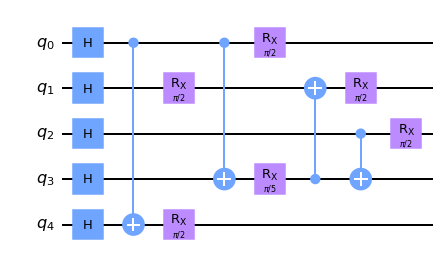

In [98]:
qc_no_cut.draw("mpl")

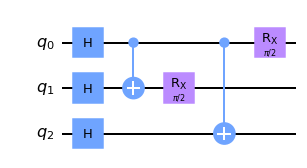

In [99]:
qc_upper.draw("mpl")

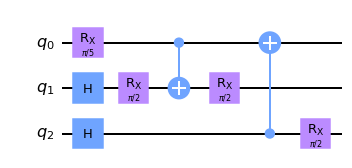

In [100]:
qc_lower.draw("mpl")

In [183]:
def one_cut(qc_upper, qc_lower, qc_no_cut, init_states):
    # hardcoded for 5 qubit, evaluating <X^5>
    qubit_states_upper = np.array([init_states[1], init_states[0], init_states[4]], dtype=np.complex128)
    qubit_states_lower = np.array([init_states[2], init_states[3], init_states[1]], dtype=np.complex128)

    state_no_cut = make_state_vector(init_states)
    exp_no_cut = state_no_cut.evolve(qc_no_cut).expectation_value(X^X^X^X^X)

    state_upper = make_state_vector(qubit_states_upper).evolve(qc_upper)
    exp_cut = 0
    for i in range(8):
        qubit_states_lower_i = qubit_states_lower
        qubit_states_lower_i[-1] = state_list[i]
        
        state_lower_i = make_state_vector(qubit_states_lower_i).evolve(qc_lower)
        exp_cut += c_list[i] * state_upper.expectation_value(O_list[i]) * state_lower_i.expectation_value(X^X^X)
        
    return exp_no_cut.real, exp_cut.real

In [186]:
exp_no_cut, exp_cut = one_cut(qc_upper, qc_lower, qc_no_cut, [z_pl, z_pl, z_pl, z_pl, z_pl])
print("<X^5> with no cut:", exp_no_cut)
print("<X^5> with one cut:", exp_cut)

<X^5> with no cut: 0.9999999999999998
<X^5> with one cut: 0.9999999999999998


- The circuit acts trivially to zero initial state. (after H gates, we have +x state for all qubits which are not affected by CNOT or rotation along x-axis) To verify the cut works in general, we test the expectation values for random initial state and see if values with and without the cut agree with each other.

In [190]:
def one_cut_random_test(qc_upper, qc_lower, qc_no_cut, shots = 100):
    exp_no_cut_list = list()
    exp_cut_list = list()
    
    for shot in range(shots):
        real_parts = np.random.uniform(low = -1, high = 1, size = (5,2))
        imag_parts = np.random.uniform(low = -1, high = 1, size = (5,2))
        qubit_states = real_parts + 1j * imag_parts
        
        exp_no_cut, exp_cut = one_cut(qc_upper, qc_lower, qc_no_cut, qubit_states)
        
        exp_no_cut_list.append(exp_no_cut)
        exp_cut_list.append(exp_cut)
        
    return exp_no_cut_list, exp_cut_list

Text(0, 0.5, '<$X^{\\otimes5}$>')

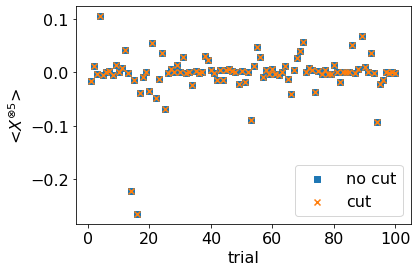

In [191]:
exp_no_cut_list, exp_cut_list = one_cut_random_test(qc_upper, qc_lower, qc_no_cut)

trials = range(1,101)
plt.scatter(trials, exp_no_cut_list, marker="s", label = "no cut")
plt.scatter(trials, exp_cut_list, marker="x", label = "cut")
plt.legend()
plt.xlabel("trial")
plt.ylabel(r"<$X^{\otimes5}$>")

# Simulation

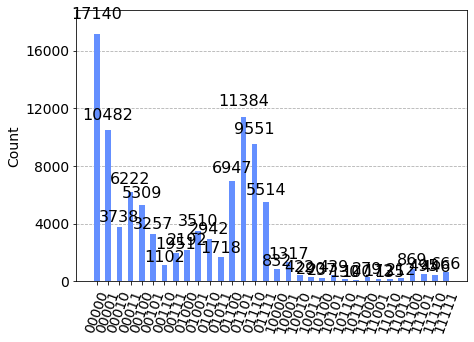

In [409]:
simulator = Aer.get_backend('aer_simulator')

real_parts = np.random.uniform(low = -1, high = 1, size = (5,2))
imag_parts = np.random.uniform(low = -1, high = 1, size = (5,2))
qubit_states = real_parts + 1j * imag_parts
#qubit_states = [y_pl, y_pl, y_pl, z_pl, z_pl]

qc_no_cut_hw = QuantumCircuit(5)
for i in range(5):
    qc_no_cut_hw.initialize(make_state_vector(qubit_states))
qc_no_cut_hw.compose(qc_no_cut, inplace=True)
qc_no_cut_hw.h([0, 1, 2, 3, 4])
qc_no_cut_hw.measure_all()
qc_no_cut_hw.draw("mpl")

qc_no_cut_hw = transpile(qc_no_cut_hw, simulator)
result = simulator.run(qc_no_cut_hw, shots=100000).result()
counts = result.get_counts(qc_no_cut_hw)

plot_histogram(counts)

In [410]:
def get_count(count, key):
    try:
        return count[key]
    except:
        return 0

exp_no_cut = 0
for i in range(32):
    key = "{0:05b}".format(i)
    if bin(i).count("1") % 2:
        exp_no_cut -= get_count(counts, key) / 100000
    else:
        exp_no_cut += get_count(counts, key) / 100000

1
2
4
7
8
11
13
14
16
19
21
22
25
26
28
31
0.0028400000000000326


- The histogram is uniformly distributed, which makes sense since we expect the qubits to be all in +x states.

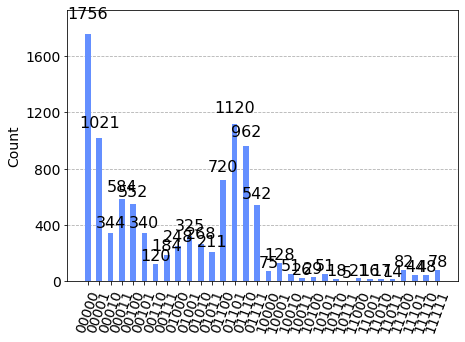

In [411]:
simulator = Aer.get_backend('aer_simulator')
qc_no_cut_hw = QuantumCircuit(5)
qc_no_cut_hw.initialize(make_state_vector(qubit_states))
qc_no_cut_hw.compose(qc_no_cut, inplace=True)
qc_no_cut_hw.h(list(range(5)))
qc_no_cut_hw.measure_all()
qc_no_cut_hw.draw("mpl")

qc_no_cut_hw = transpile(qc_no_cut_hw, simulator)
result = simulator.run(qc_no_cut_hw, shots=10000).result()
counts = result.get_counts(qc_no_cut_hw)

plot_histogram(counts)

- Measuring in x-basis we explicitly confirm that the qubits are all in +x state at the output, so <X^5> would be simply +1.

In [412]:
state_labels = ["0", "1", "+", "-", "l", "r", "0", "1"]
basis_list = ["Z", "Z", "X", "X", "Y", "Y", "Z", "Z"]

upper_count_list = list()
lower_count_list = list()

qubit_states_upper = np.array([qubit_states[1], qubit_states[0], qubit_states[4]], dtype=np.complex128)
qubit_states_lower = np.array([qubit_states[2], qubit_states[3], qubit_states[1]], dtype=np.complex128)

for i in range(8):
    qc_upper_hw = QuantumCircuit(3)
    qc_lower_hw = QuantumCircuit(3)
    
    qc_upper_hw.initialize(make_state_vector(qubit_states_upper))
    qubit_states_lower_i = qubit_states_lower
    qubit_states_lower_i[-1] = state_list[i]
    qc_lower_hw.initialize(make_state_vector(qubit_states_lower_i))
    
    qc_lower_hw.compose(qc_lower, inplace=True)
    qc_upper_hw.compose(qc_upper, inplace=True)
    
    qc_upper_hw.h([0, 1])
    
    if basis_list[i] == "X":
        qc_upper_hw.h(2)
    elif basis_list[i] == "Y":
        qc_upper_hw.h(2)
        qc_upper_hw.sdg(2)
        qc_upper_hw.h(2)
    else:
        pass
    
    qc_lower_hw.h([0, 1, 2])
    
    qc_upper_hw.measure_all()
    qc_lower_hw.measure_all()

    qc_upper_hw = transpile(qc_upper_hw, simulator)
    qc_lower_hw = transpile(qc_lower_hw, simulator)

    result_upper = simulator.run(qc_upper_hw, shots=10000).result()
    result_lower = simulator.run(qc_lower_hw, shots=10000).result()
    
    upper_count_list.append(result_upper.get_counts(qc_upper_hw))
    lower_count_list.append(result_lower.get_counts(qc_lower_hw))

In [413]:
qubit_states_upper.shape

(3, 2)

In [414]:
exp_upper_list = list()
exp_lower_list = list()

def get_count(count, key):
    try:
        return count[key]
    except:
        return 0

exp_upper_list.append((get_count(upper_count_list[0], "000") - \
                       get_count(upper_count_list[0], "001") - \
                       get_count(upper_count_list[0], "010") + \
                       get_count(upper_count_list[0], "011") + \
                       get_count(upper_count_list[0], "100") - \
                       get_count(upper_count_list[0], "101") - \
                       get_count(upper_count_list[0], "110") + \
                       get_count(upper_count_list[0], "111")) / 10000)
exp_upper_list.append(exp_upper_list[-1])
for i in range(2, 8, 2):
    exp_upper_list.append((get_count(upper_count_list[i], "000") - \
                           get_count(upper_count_list[i], "001") - \
                           get_count(upper_count_list[i], "010") + \
                           get_count(upper_count_list[i], "011") - \
                           get_count(upper_count_list[i], "100") + \
                           get_count(upper_count_list[i], "101") + \
                           get_count(upper_count_list[i], "110") - \
                           get_count(upper_count_list[i], "111")) / 10000)
    exp_upper_list.append(exp_upper_list[-1])
for i in range(8):
    exp_lower_list.append((get_count(lower_count_list[i], "000") - \
                           get_count(lower_count_list[i], "001") - \
                           get_count(lower_count_list[i], "010") + \
                           get_count(lower_count_list[i], "011") - \
                           get_count(lower_count_list[i], "100") + \
                           get_count(lower_count_list[i], "101") + \
                           get_count(lower_count_list[i], "110") - \
                           get_count(lower_count_list[i], "111")) / 10000)
print(exp_upper_list)
print(exp_lower_list)

[0.046, 0.046, 0.257, 0.257, -0.3998, -0.3998, 0.8158, 0.8158]
[0.1334, 0.1608, 0.164, 0.1444, 0.1528, 0.156, 0.1534, 0.16]


In [415]:
exp_cut = 0
for i in range(8):
    exp_cut += c_list[i] * exp_upper_list[i] * exp_lower_list[i]
print(exp_cut)

0.007232740000000001


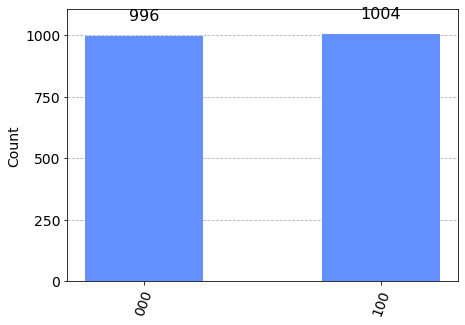

In [387]:
counts = result_upper.get_counts(qc_upper_hw)
plot_histogram(counts)

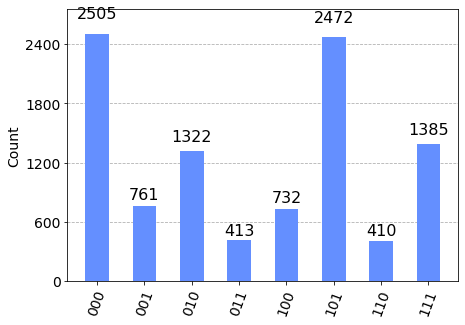

In [416]:
counts = result_lower.get_counts(qc_lower_hw)
plot_histogram(counts)